In [1]:
from sctoolbox.utils.jupyter import bgcolor, _compare_version

nb_name = "04_clustering.ipynb"

_compare_version(nb_name)

/home/jdetlef/.conda/envs/sctoolbox/lib/python3.10/site-packages/sctoolbox/utils/jupyter.py:108: UserWarning: The notebook has an older version compared to the installed sctoolbox version (0.10.1 < 0.10.2b0). Some functions may not work!
  warnings.warn(f"The notebook has {ver_dif} version compared to the installed sctoolbox version ({nb_ver} {arrow} {sc_ver}). Some functions may not work!")


#  04 - Embedding and clustering
<hr style="border:2px solid black"> </hr>

## 1 - Description
This notebook aims to group cells based on how similar their gene expression profiles are. Ideally, the resulting clusters should represent different cell types. This grouping is achieved in two steps: **Embedding** and **Clustering**.

### 1.1 Embedding
Embeddings are dimension reduction methods to transform high-dimensional data into lower-dimensional representations while preserving the inherent structure and relationships between individual cells.  
The sctoolbox supports the [Uniform Manifold Approximation and Projection (UMAP)](https://arxiv.org/abs/1802.03426) and the [t-distributed stochastic neighbor embedding (t-SNE)](https://www.jmlr.org/papers/volume9/vandermaaten08a/vandermaaten08a.pdf) methods for dimension reduction, with UMAP being set as the default value.
To learn more about the differences between those methods and get more insight in the parameter selction have a look [here for umap](https://pair-code.github.io/understanding-umap/) and [here for t-SNE](https://distill.pub/2016/misread-tsne/?_ga=2.135835192.888864733.1531353600-1779571267.1531353600).
### 1.2 Clustering
Single cell clustering is used to group individual cells into clusters based on similarities in their gene expression. The clustering allows to identify distinct cell types and characterize cellular heterogeneity within a population.
The sctoolbox supports the [leiden](https://www.nature.com/articles/s41598-019-41695-z) and the [louvain](https://iopscience.iop.org/article/10.1088/1742-5468/2008/10/P10008) clustering methods, with the leiden clustering algorithm being newer and recommended to use.

__________

## 2 - Setup

In [8]:
import scanpy as sc
import pandas as pd

import sctoolbox
import sctoolbox.tools as tools
import sctoolbox.plotting as pl
import sctoolbox.utils as utils

sctoolbox.settings.settings_from_config("config.yaml", key="04")

sc.set_figure_params(vector_friendly=True, dpi_save=600, scanpy=False)

[WARNING] Log file '../logs/04_log.txt' already exists. The file will be overwritten since 'overwrite_log' is set to True.


__________

## 3 - Load anndata

In [9]:
adata = utils.adata.load_h5ad("anndata_3.h5ad")

with pd.option_context("display.max.rows", 5, "display.max.columns", None):
    display(adata)
    display(adata.obs)
    display(adata.var)

[INFO] The adata object was loaded from: ../adatas/anndata_3.h5ad


AnnData object with n_obs × n_vars = 1917 × 105042
    obs: 'TN', 'UM', 'PP', 'UQ', 'CM', 'file', 'sample', 'nucleosome_signal', 'fld_score', 'mean_fragment_size', 'n_fragments', 'fold_change_promoters_fragments', 'frip', 'tsse_score', 'catlas_ov', 'cell type', 'closest Cell Ontology term(s)', 'ontology', 'muon-01-07', 'tc-150', 'fld-100', 'n_features', 'log1p_n_features'
    var: 'peak_chr', 'peak_start', 'peak_end', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'highly_variable'
    uns: 'files', 'lsi', 'neighbors', 'pca', 'sctoolbox'
    obsm: 'X_lsi', 'X_pca'
    varm: 'LSI', 'PCs'
    layers: 'raw'
    obsp: 'connectivities', 'distances'

TN      UM      PP      UQ     CM  \
barcode                                                         
AAACTACCAGAAACGGATCAGT  3692.0  3009.0  3004.0  3004.0   69.0   
AAACTACCAGACATAGTGGCGT  5811.0  4812.0  4804.0  4804.0  241.0   
...                        ...     ...     ...     ...    ...   
TTCCATCCTCTGCAGAACAGTG  2995.0  2502.0  2493.0  2493.0  227.0   
TTCCATCCTCTGCTAGCCTATA  1498.0  1140.0  1138.0  1138.0  149.0   

                                                                     file  \
barcode                                                                     
AAACTACCAGAAACGGATCAGT  /mnt/workspace2/jdetlef/peakqc_paperprep/bench...   
AAACTACCAGACATAGTGGCGT  /mnt/workspace2/jdetlef/peakqc_paperprep/bench...   
...                                                                   ...   
TTCCATCCTCTGCAGAACAGTG  /mnt/workspace2/jdetlef/peakqc_paperprep/bench...   
TTCCATCCTCTGCTAGCCTATA  /mnt/workspace2/jdetlef/peakqc_paperprep/bench...   

                       sample  nucleosome_signal   fld_score  \
barcode                                                        
AAACTACCAGAAACGGATCAGT     MB           0.462500  184.560884   
AAACTACCAGACATAGTGGCGT     MB           0.458333  117.677077   
...                       ...                ...         ...   
TTCCATCCTCTGCAGAACAGTG     MB           0.418182  222.135761   
TTCCATCCTCTGCTAGCCTATA     MB           0.500000  132.282873   

                        mean_fragment_size  n_fragments  \
barcode                                                   
AAACTACCAGAAACGGATCAGT              137.64       2933.0   
AAACTACCAGACATAGTGGCGT              132.98       4822.0   
...                                    ...          ...   
TTCCATCCTCTGCAGAACAGTG              134.31       2325.0   
TTCCATCCTCTGCTAGCCTATA              134.22       1140.0   

                        fold_change_promoters_fragments      frip  tsse_score  \
barcode                                                                         
AAACTACCAGAAACGGATCAGT                         0.171838  0.086260    1.208600   
AAACTACCAGACATAGTGGCGT                         0.356076  0.091456    0.568560   
...                                                 ...       ...         ...   
TTCCATCCTCTGCAGAACAGTG                         0.372043  0.340645    3.709360   
TTCCATCCTCTGCTAGCCTATA                         0.828947  0.169298    0.509529   

                        catlas_ov cell type closest Cell Ontology term(s)  \
barcode                                                                     
AAACTACCAGAAACGGATCAGT      False       NaN                           NaN   
AAACTACCAGACATAGTGGCGT      False       NaN                           NaN   
...                           ...       ...                           ...   
TTCCATCCTCTGCAGAACAGTG      False       NaN                           NaN   
TTCCATCCTCTGCTAGCCTATA      False       NaN                           NaN   

                       ontology  muon-01-07  tc-150  fld-100  n_features  \
barcode                                                                    
AAACTACCAGAAACGGATCAGT      NaN        True   False     True         243   
AAACTACCAGACATAGTGGCGT      NaN        True    True     True         287   
...                         ...         ...     ...      ...         ...   
TTCCATCCTCTGCAGAACAGTG      NaN       False   False     True         734   
TTCCATCCTCTGCTAGCCTATA      NaN       False   False     True         153   

                        log1p_n_features  
barcode                                   
AAACTACCAGAAACGGATCAGT          5.497168  
AAACTACCAGACATAGTGGCGT          5.662960  
...                                  ...  
TTCCATCCTCTGCAGAACAGTG          6.599870  
TTCCATCCTCTGCTAGCCTATA          5.036953  

[1917 rows x 23 columns]

peak_chr  peak_start  peak_end  n_cells_by_counts  \
name                                                                       
chr1:10007-10565           chr1       10007     10565                  9   
chr1:11182-11364           chr1       11182     11364                  0   
...                         ...         ...       ...                ...   
chrY:56870833-56870955     chrY    56870833  56870955                 16   
chrY:56886632-56886906     chrY    56886632  56886906                  7   

                        mean_counts  log1p_mean_counts  pct_dropout_by_counts  \
name                                                                            
chr1:10007-10565           0.004695           0.004684              99.530516   
chr1:11182-11364           0.000000           0.000000             100.000000   
...                             ...                ...                    ...   
chrY:56870833-56870955     0.009390           0.009346              99.165363   
chrY:56886632-56886906     0.003652           0.003645              99.634846   

                        total_counts  log1p_total_counts  highly_variable  
name                                                                       
chr1:10007-10565                 9.0            2.302585             True  
chr1:11182-11364                 0.0            0.000000            False  
...                              ...                 ...              ...  
chrY:56870833-56870955          18.0            2.944439            False  
chrY:56886632-56886906           7.0            2.079442             True  

[105042 rows x 10 columns]

_______

## 4 - General input
Choose the embedding and clustering method and adjust the range of parameters for each one of them. The specific parameters for **embedding** (`section 5`) and **clustering** (`section 7`) can be chosen after visually inspecting the results.

<h1><center>⬐ Fill in input data here ⬎</center></h1>

In [2]:
%bgcolor PowderBlue

# Column to show in UMAPs
condition_column = 'sample'

# Number of threads to use for multiprocessing
threads = 4

# Search embedding parameters
embedding = "umap"  # umap or tsne
search_parameters = True

# UMAP parameters
dist_range = (0.1, 0.31, 0.1)  # Set min_dist range for umap
spread_range = (1, 2.5, 0.5)  # Set spread range for umap
n_components = 2  # Number of components for umap (>=3 enables 3d UMAP but likely degrades 2d results)

# t-SNE parameters
perplexity_range = (30, 60, 10)  # perplexity range for tsne
learning_rate_range = (400, 1000, 200)  # learning_rate for tsne

# Search different clustering resolutions
search_clustering_parameters = True
cluster_res_range = (0.1, 1, 0.1)  # Set the searched resolution range from low to high resolution (less to more clusters).
clustering_method = "leiden"  # leiden or louvain
cluster_ncols = 4  # Number of columns displayed in the plot

# Annotate regions to genes
GTF_PATH = "test_data/hg38_genes.gtf"  # genes gtf file

_______

## 5 - Calculate UMAP/TSNE and find the best setting
<hr style="border:2px solid black"> </hr>

After visually inspecting the results, adjust the parameters shown below for the best embedding. While it is somewhat subjective what the "best" parameters for an embedding should be, the chosen embedding should display clear structures that are neither spread too thin nor too clumped up.

### 5.1 Parameter overview

|Method|Parameter|Description|
|------|---------|-----------|
|[UMAP](https://scanpy.readthedocs.io/en/stable/generated/scanpy.tl.umap.html)|`min_dist`|Distances between points to make the plot look more 'clustered'.|
|[UMAP](https://scanpy.readthedocs.io/en/stable/generated/scanpy.tl.umap.html)|`spread`|The effective scale of embedded points. Relative to `min_dist`|
|[tSNE](https://scanpy.readthedocs.io/en/stable/generated/scanpy.tl.tsne.html)|`perplexity`|Related to the number of nearest-neighbors accounted for during embedding creation. Larger datasets require bigger values.|
|[tSNE](https://scanpy.readthedocs.io/en/stable/generated/scanpy.tl.tsne.html)|`learning_rate`|Can be important for embedding cluster formation.|

Computing UMAPs:   0%|          | 0/9 [00:00<?, ?it/s]

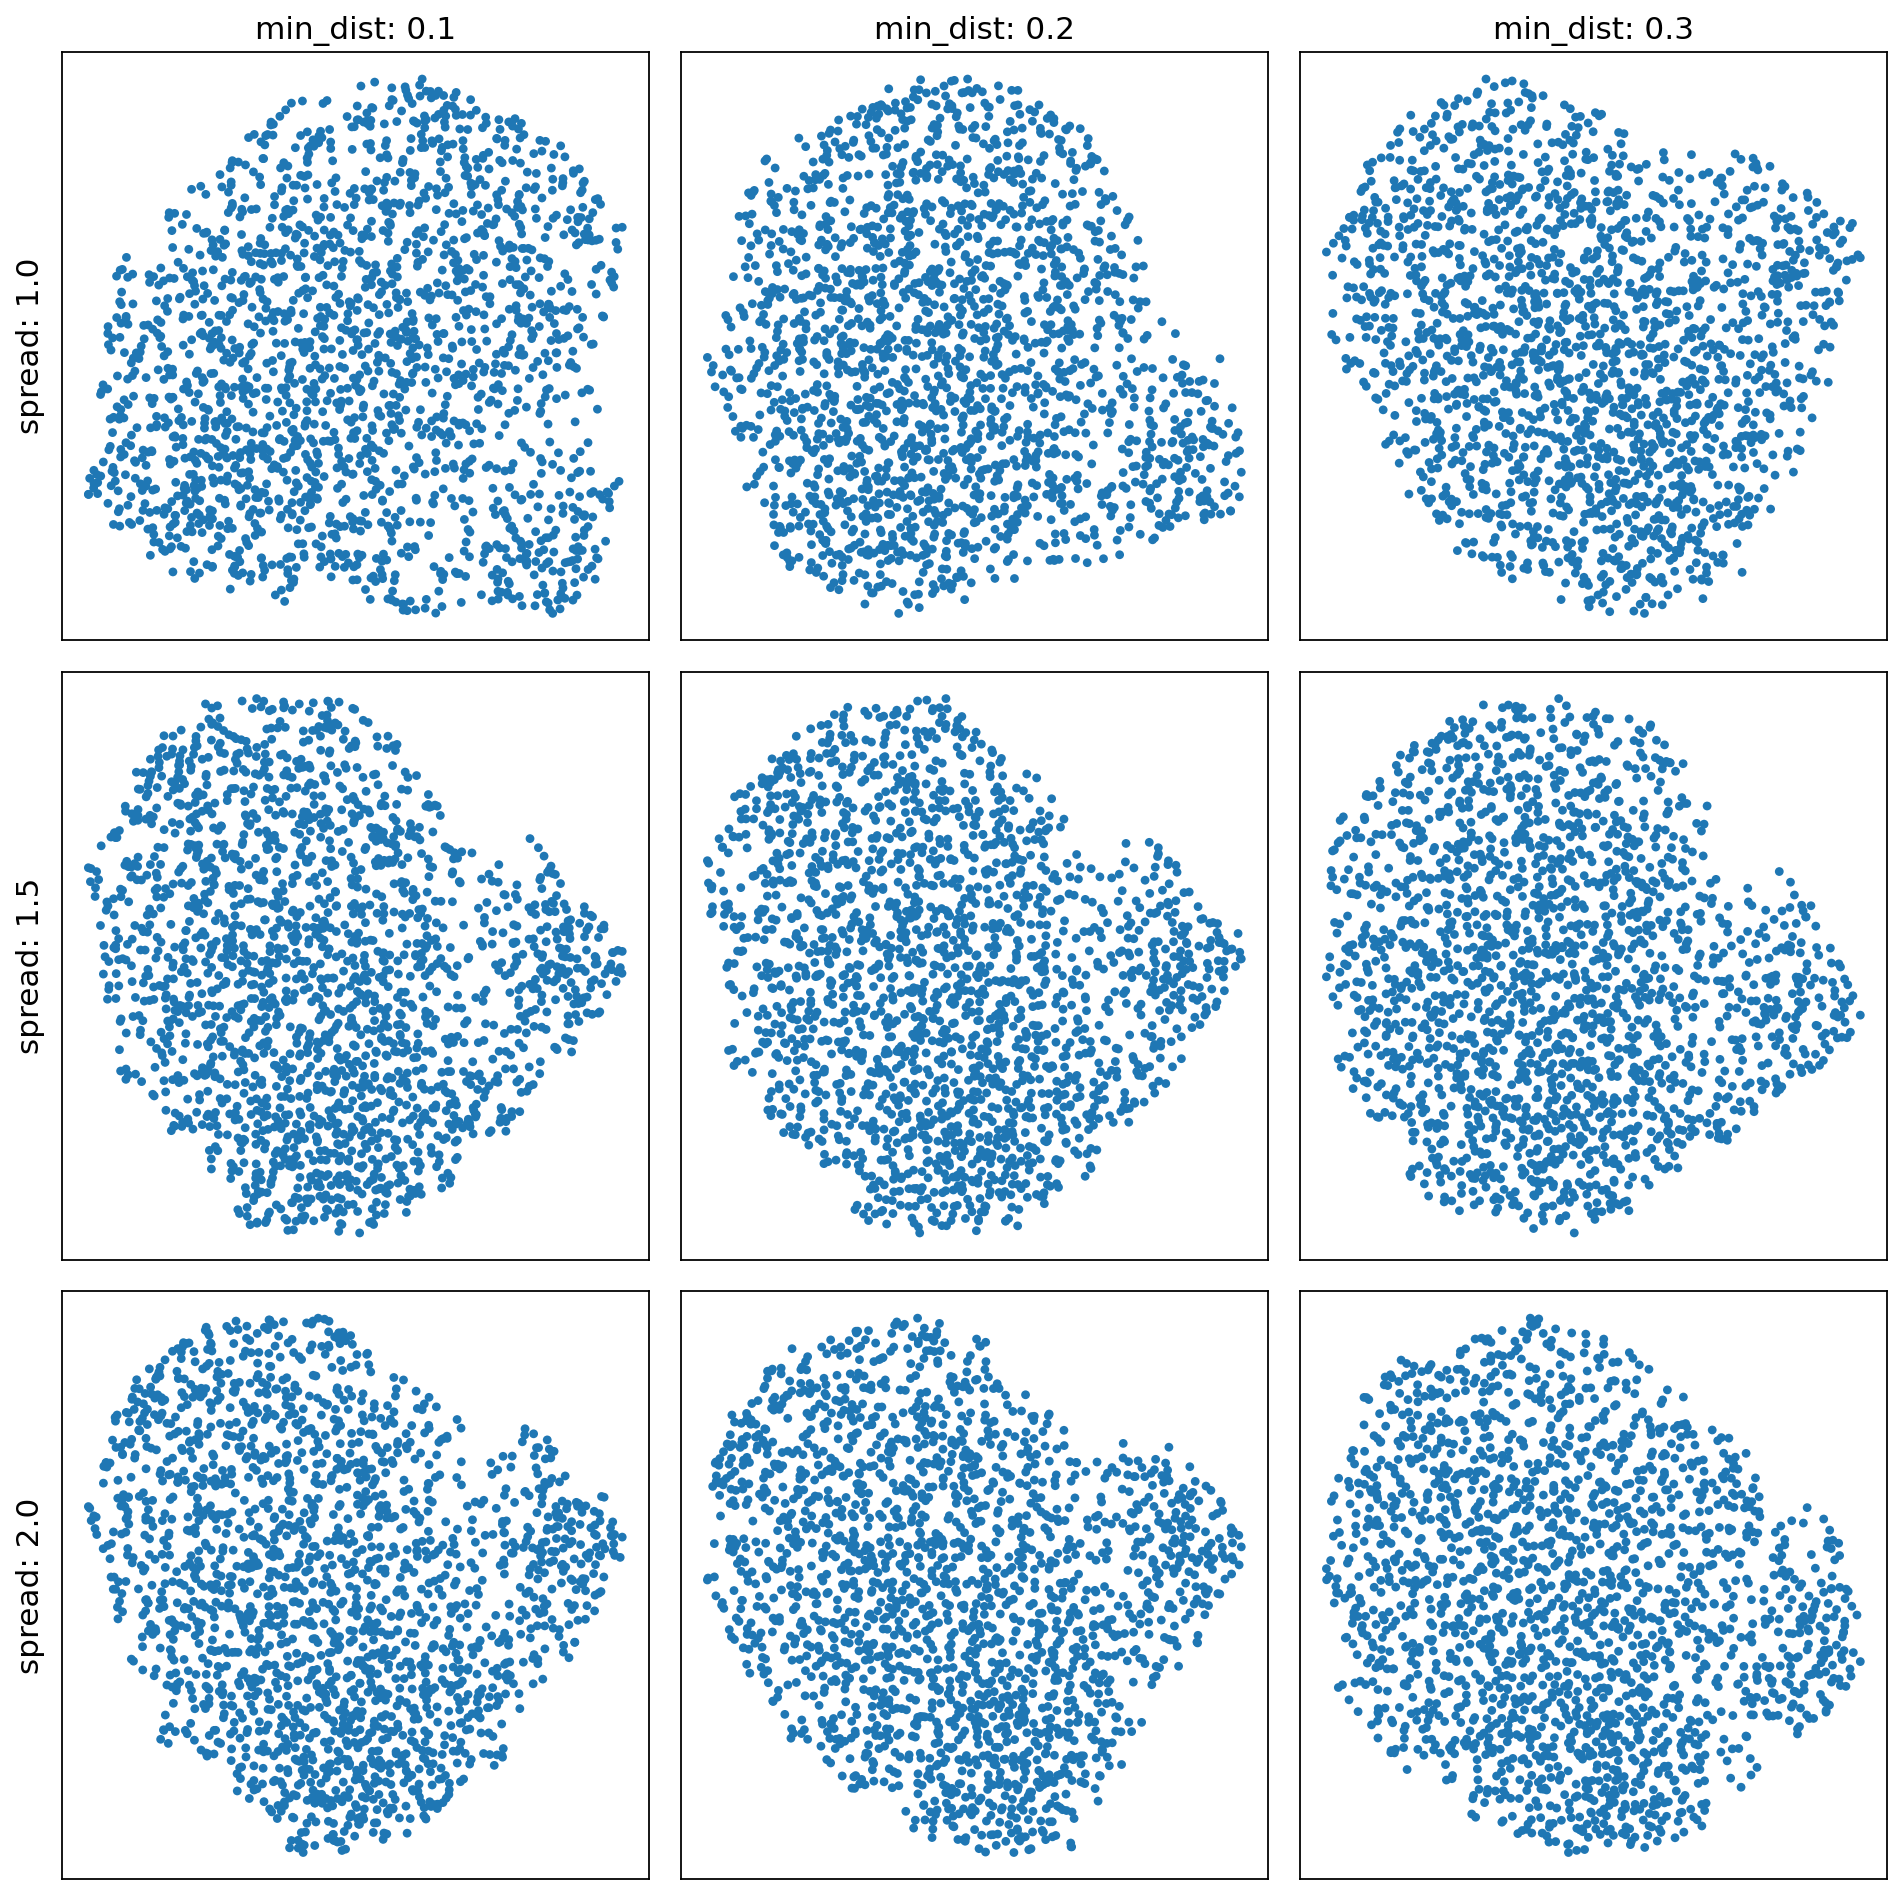

In [11]:
if search_parameters:
    if embedding == "umap":
        pl.embedding.search_umap_parameters(
            adata, 
            min_dist_range=dist_range,
            spread_range=spread_range,
            color=condition_column,
            n_components=n_components,
            threads=threads,
            save="UMAP_parameter_search.pdf"
        )
    elif embedding == "tsne":
        pl.embedding.search_tsne_parameters(
            adata, 
            perplexity_range=perplexity_range,
            learning_rate_range=learning_rate_range,
            color=condition_column,
            threads=threads,
            save="TSNE_parameter_search.pdf"
        )

<h1><center>⬐ Fill in input data here ⬎</center></h1>

In [3]:
%bgcolor PowderBlue

# Final choice of spread / dist for umap
min_dist = 0.1
spread = 1.0

# Final choice of perplexity / learning_rate for tsne
perplexity = 50
learning_rate = 800

_________

In [13]:
# Calculate final embedding
if embedding == "umap":
    sc.tl.umap(adata, min_dist=min_dist, spread=spread, n_components=n_components)
elif embedding == "tsne":
    sc.tl.tsne(adata, perplexity=perplexity, learning_rate=learning_rate)

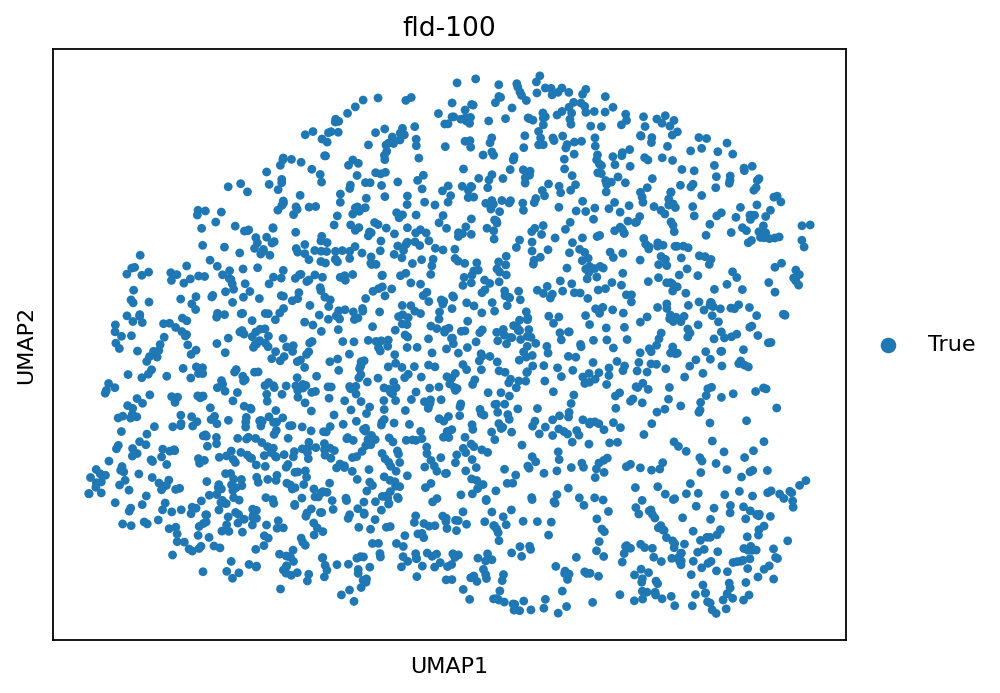

In [14]:
sc.pl.umap(adata, color='fld-100')

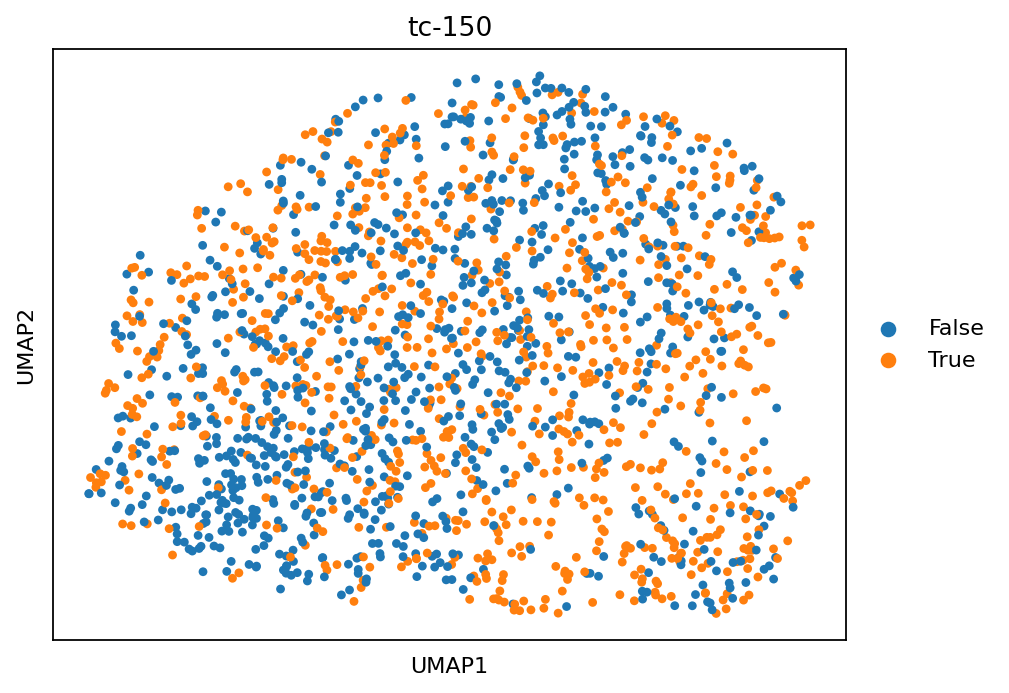

In [15]:
sc.pl.umap(adata, color='tc-150')

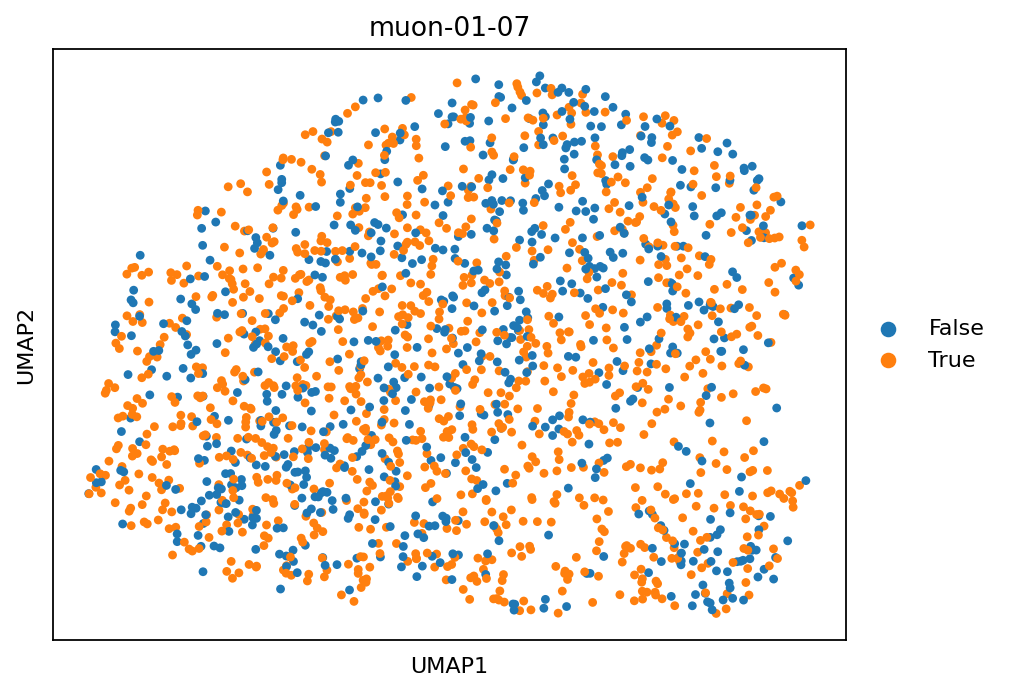

In [16]:
sc.pl.umap(adata, color='muon-01-07')

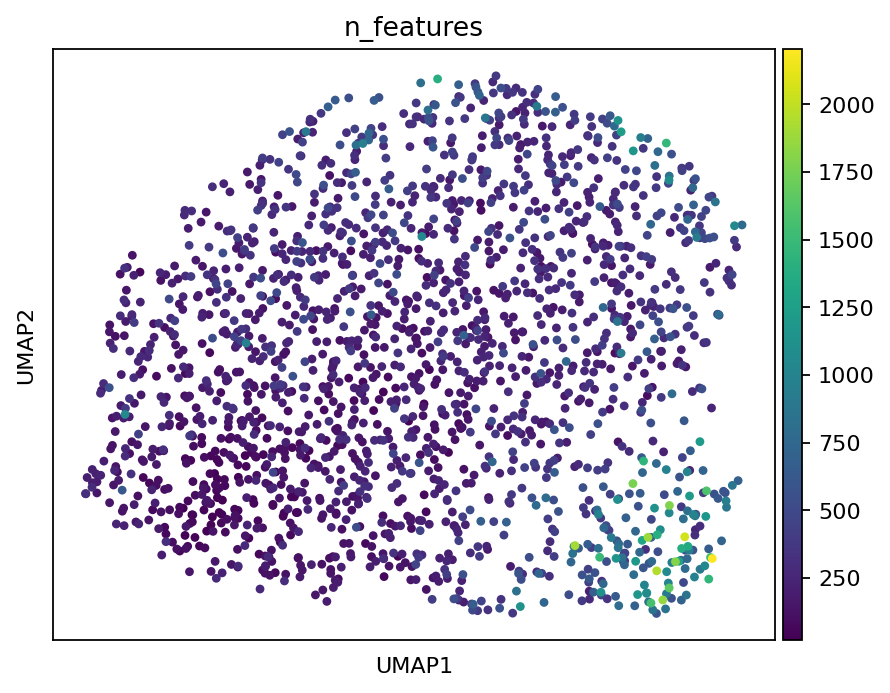

In [170]:
sc.pl.umap(adata, color='n_features')

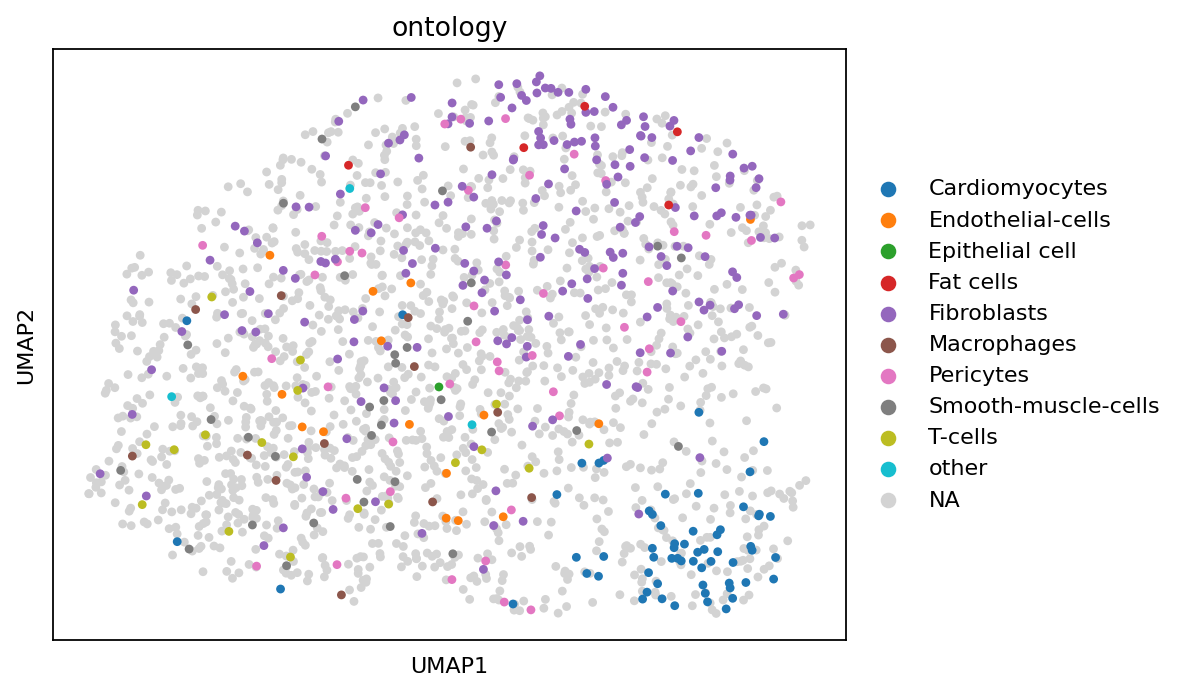

In [172]:
sc.pl.umap(adata, color='ontology', save='-random-ontology-peakqc.png')

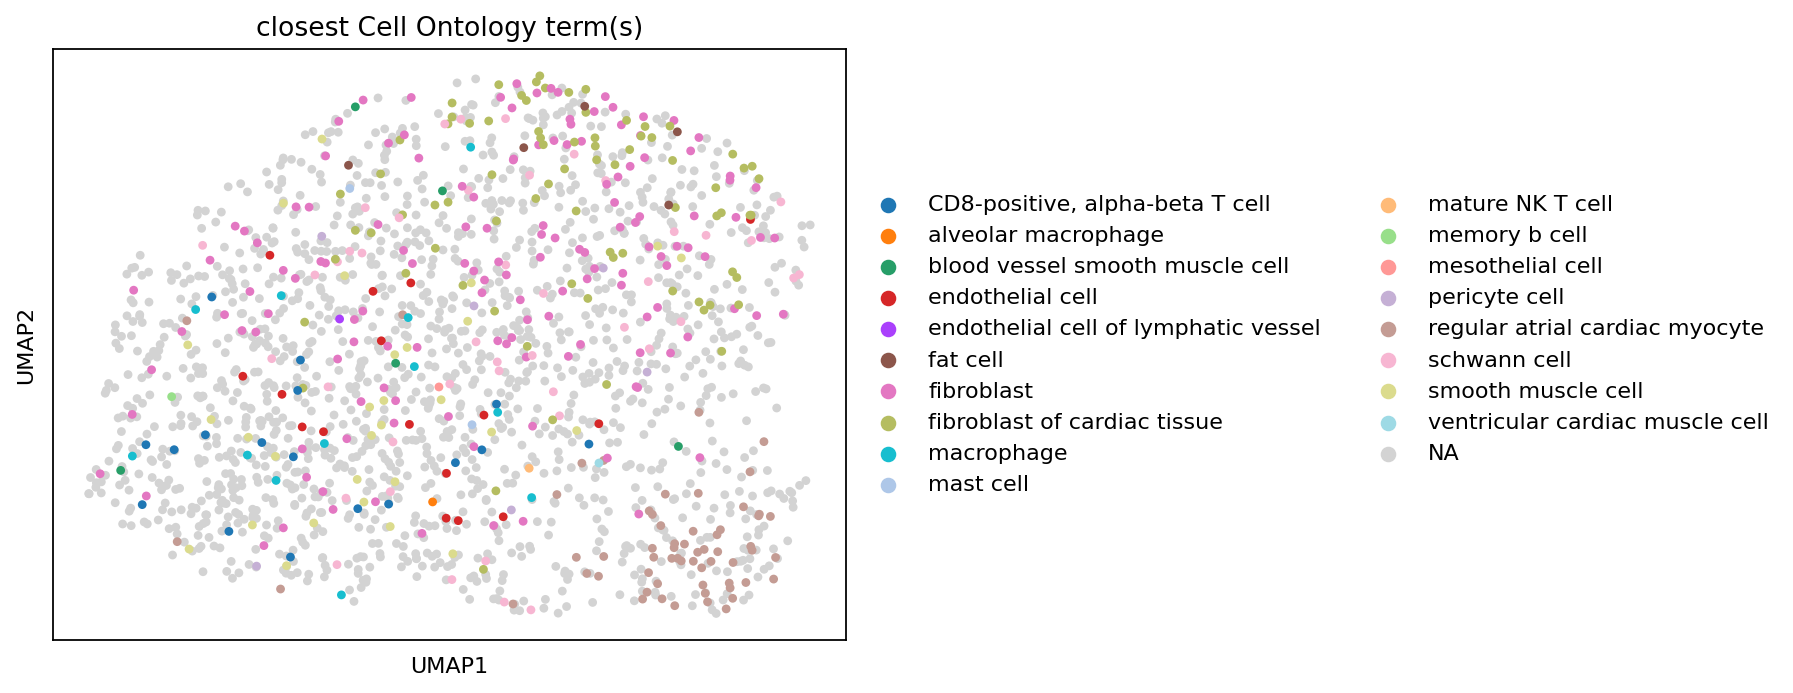

In [19]:
sc.pl.umap(adata, color='closest Cell Ontology term(s)')

In [20]:
adata.obs.columns

Index(['TN', 'UM', 'PP', 'UQ', 'CM', 'file', 'sample', 'nucleosome_signal',
       'fld_score', 'mean_fragment_size', 'n_fragments',
       'fold_change_promoters_fragments', 'frip', 'tsse_score', 'catlas_ov',
       'cell type', 'closest Cell Ontology term(s)', 'ontology', 'muon-01-07',
       'tc-150', 'fld-100', 'n_features', 'log1p_n_features'],
      dtype='object')

___________

## 6 - Cell clustering
<hr style="border:2px solid black"> </hr>

This step assigns each cell into a cluster. Cells in the same cluster are assumed to be of the same cell type. Cells are assigned based on their distance within the nearest neighbor graph, which is loosely equivalent to their distance within the embedding. The resolution controls the coarseness of the clustering. A lower resolution results in fewer larger clusters, while a higher resolution results in more smaller clusters.

- `clustering_column`: To choose a resolution, change the number in `leiden_0.5`, for example `leiden_0.1` for a resolution of `0.1`. Higher values lead to more clusters.

[INFO] Plotting umap for resolution=0.1 (1 / 9)
[INFO] Plotting umap for resolution=0.2 (2 / 9)
[INFO] Plotting umap for resolution=0.3 (3 / 9)
[INFO] Plotting umap for resolution=0.4 (4 / 9)
[INFO] Plotting umap for resolution=0.5 (5 / 9)
[INFO] Plotting umap for resolution=0.6 (6 / 9)
[INFO] Plotting umap for resolution=0.7 (7 / 9)
[INFO] Plotting umap for resolution=0.8 (8 / 9)
[INFO] Plotting umap for resolution=0.9 (9 / 9)


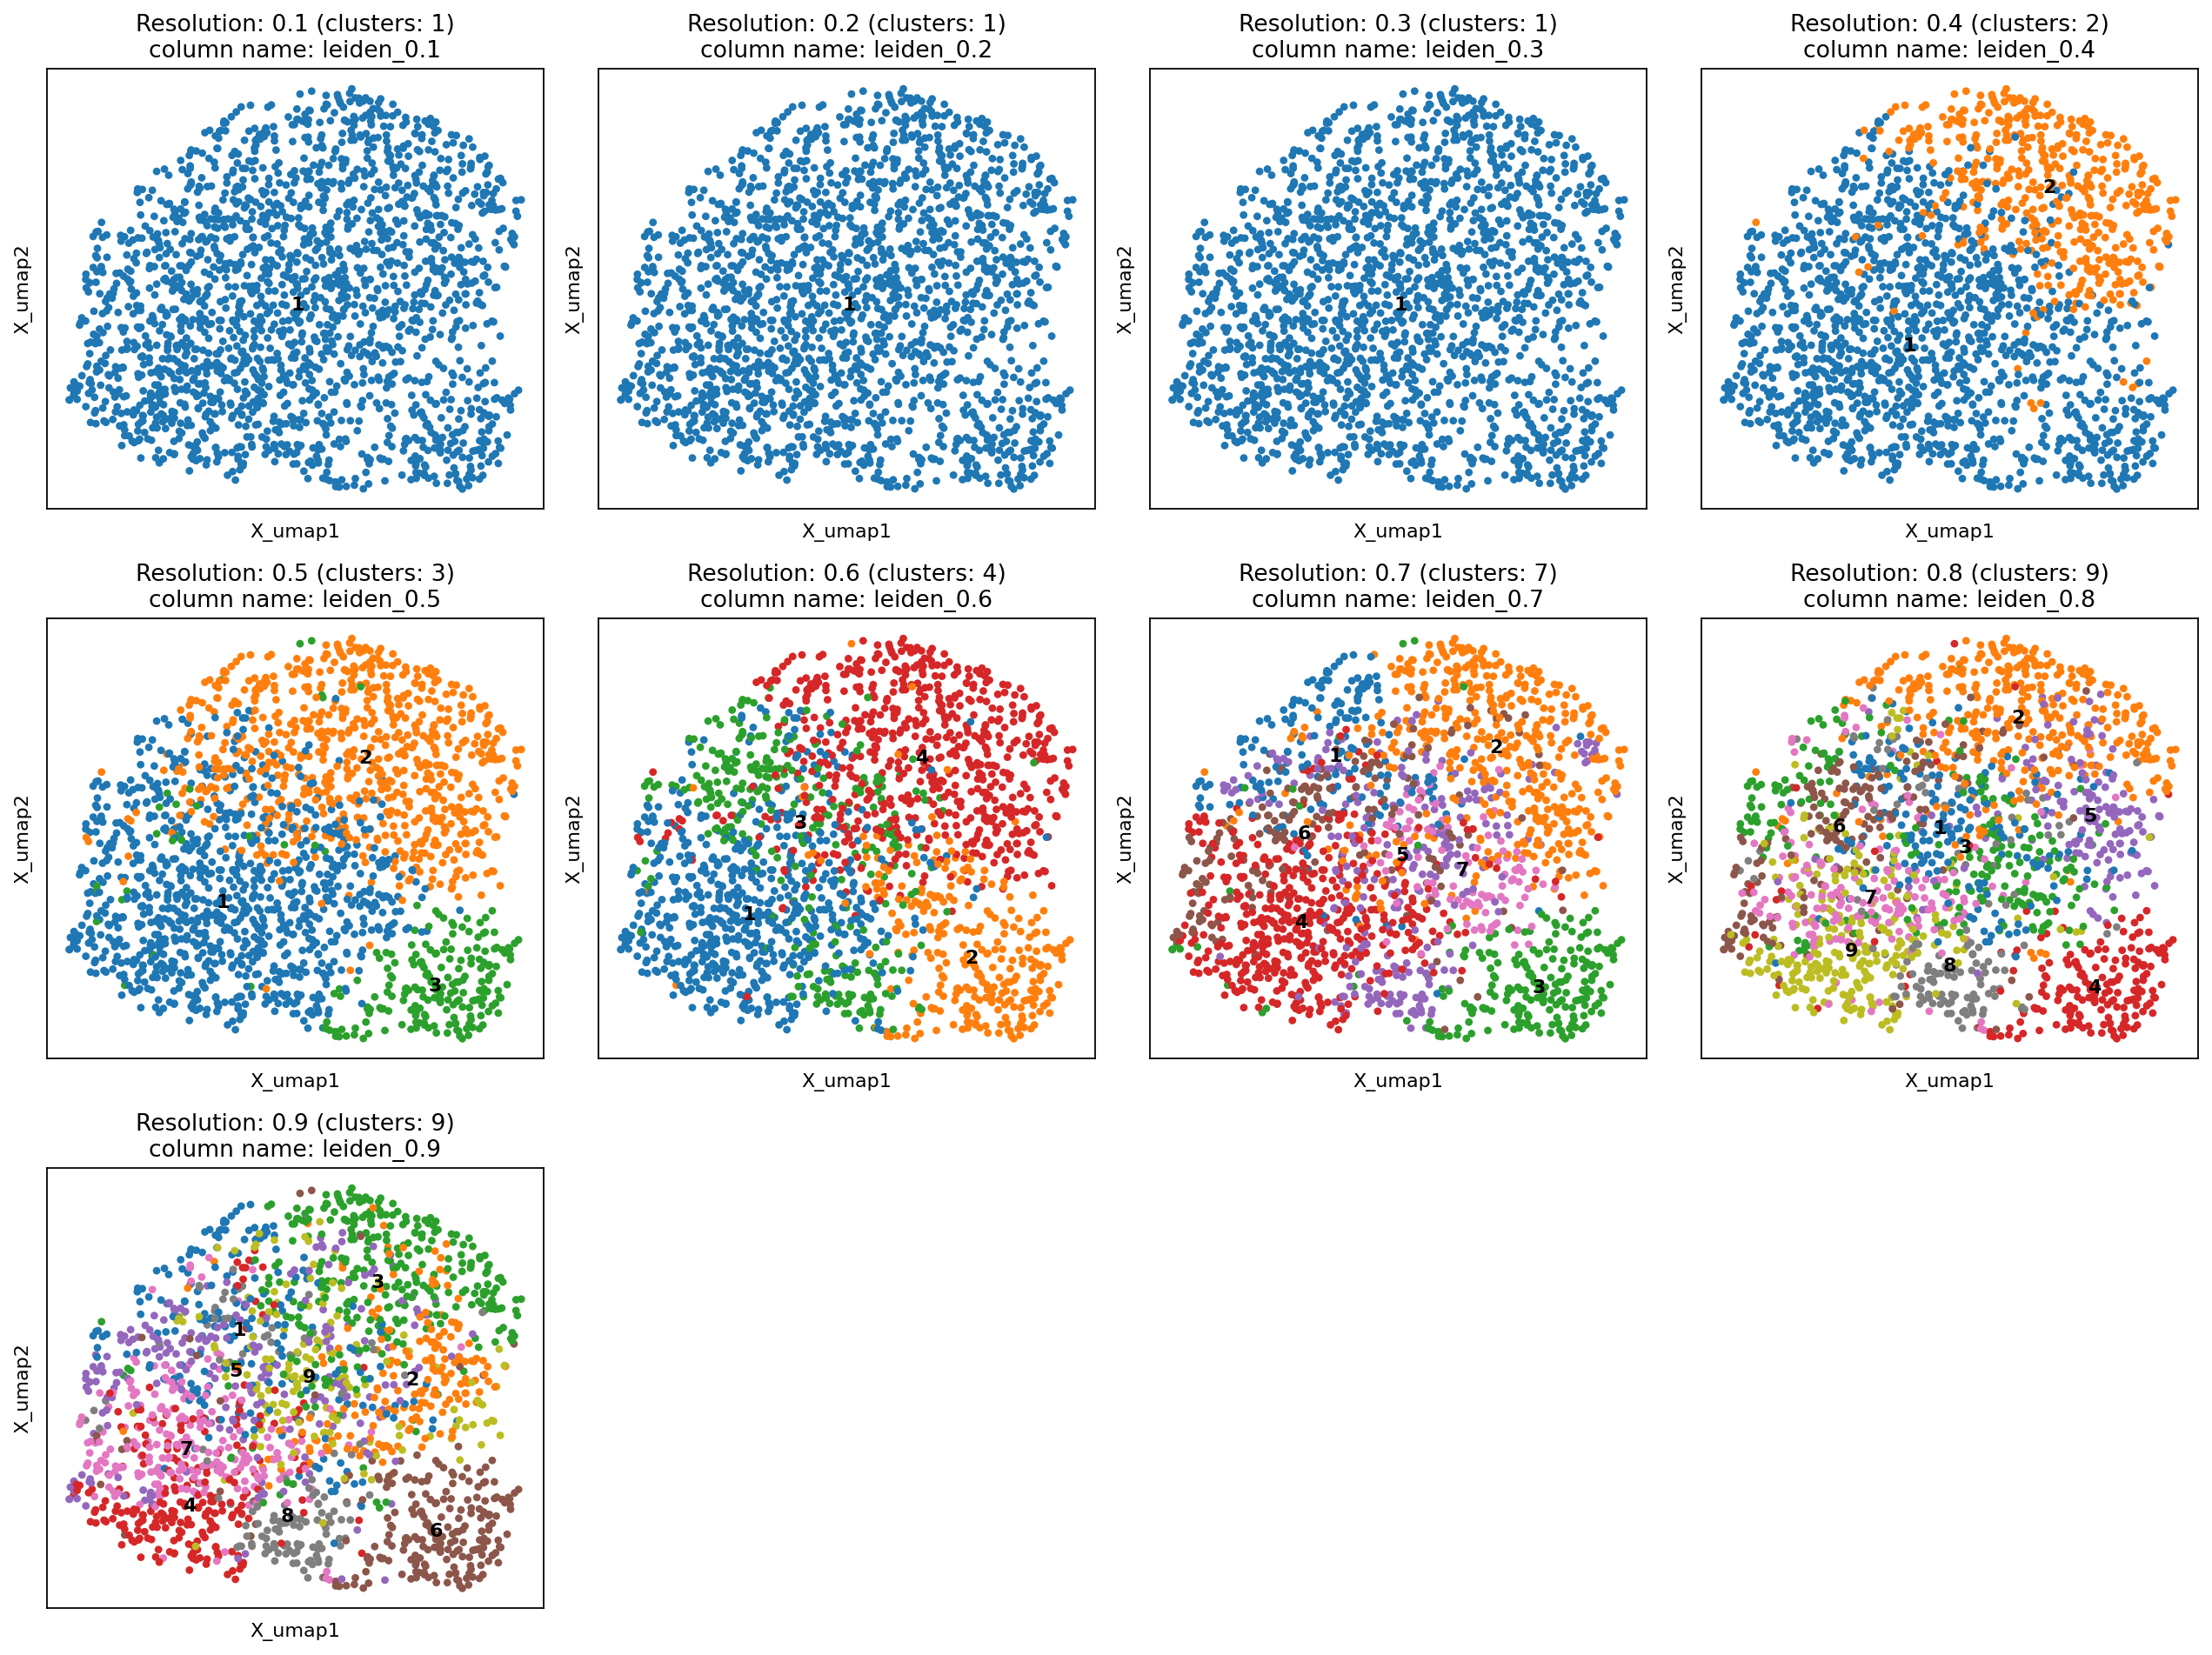

In [28]:
# plot different clustering resolutions
if search_clustering_parameters:
    pl.clustering.search_clustering_parameters(
        adata,
        ncols=cluster_ncols,
        method=clustering_method,
        embedding=embedding,
        resolution_range=cluster_res_range,
        save="clustering_search.png")

<h1><center>⬐ Fill in input data here ⬎</center></h1>

In [4]:
%bgcolor PowderBlue

# choose final resolution
clustering_column = "leiden_0.6"

_________

### 6.1 - Revise clustering (optional)
Here you can use the `tools.clustering.recluster` function to iteratively adjust clustering. The two cells below are provided as a template for either *joining* clusters (first cell) or *splitting* clusters (second cell). Fill in the list at the top of the respective cell to activate *joining* or *splitting*. You can __copy the cells as needed__ for more combining and splitting steps.

In [5]:
%bgcolor PowderBlue
# combine multiple clusters into one
# skipped when empty
combine = []  # add cluster names

if combine:
    tools.clustering.recluster(
        adata=adata,
        column=clustering_column,
        clusters=combine,
        task="join",
        embedding=embedding,
        key_added="recluster"
    )

    clustering_column = "recluster"

In [6]:
%bgcolor PowderBlue
# split (recluster) one or more clusters
# skipped when empty
split = []  # add cluster names
resolution = 0.15  # 0-1, small values create less clusters

if split:
    tools.clustering.recluster(
        adata=adata, 
        column=clustering_column,
        clusters=split,
        task="split",
        resolution=resolution,
        embedding=embedding,
        key_added="recluster"
    )

    clustering_column = "recluster"

In [128]:
 # Create final clustering
adata.obs["clustering"] = utils.tables.rename_categories(adata.obs[clustering_column])

___________

### 6.2 - Final clustering of cells

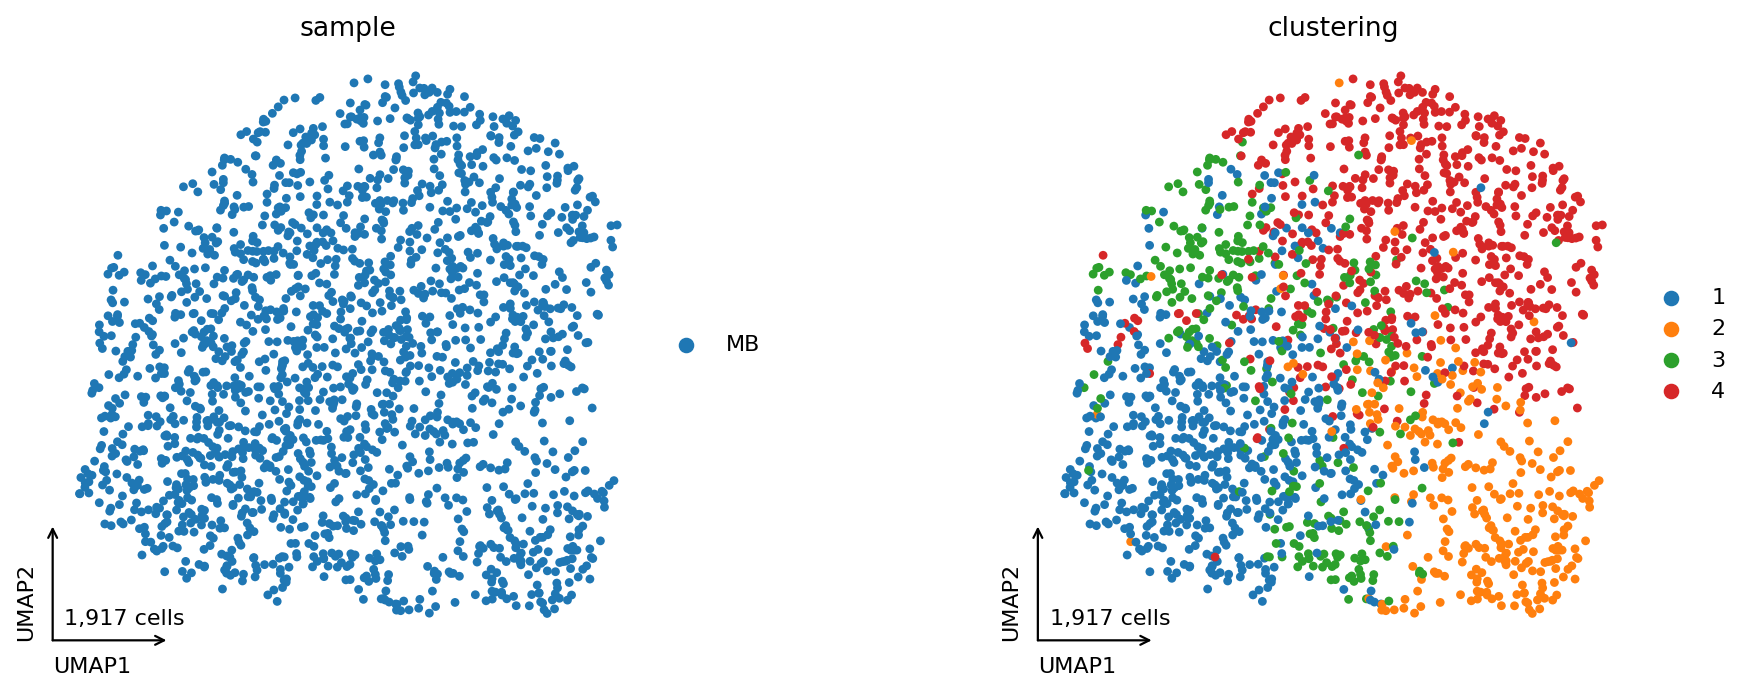

In [130]:
# Plot final leiden
_ = pl.embedding.plot_embedding(adata=adata,
                                basis=f"X_{embedding}",
                                method=embedding,
                                color=[condition_column, "clustering"],
                                save="embedding_clustering.png")

___________

<AxesSubplot: >

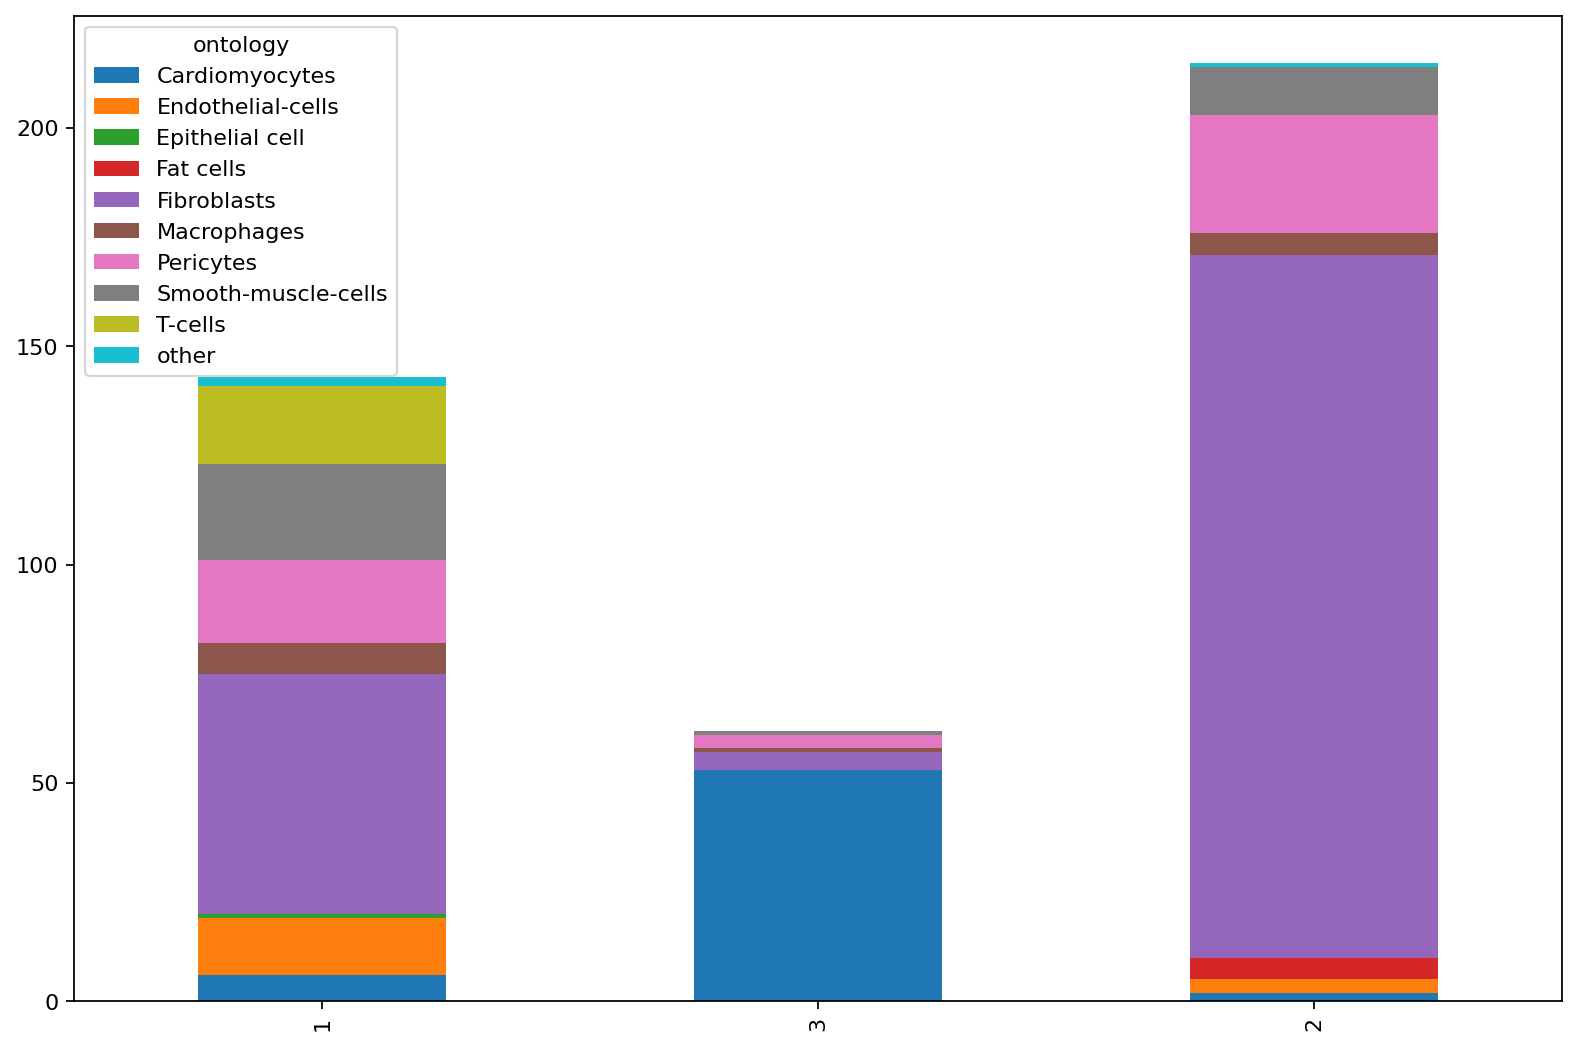

In [65]:
changes = {}

for i, cluster in enumerate(adata.obs['clustering'].unique()):
    counts = adata.obs[adata.obs['clustering'] == cluster].value_counts('catlas_ov')
    ontologies = adata.obs[adata.obs['clustering'] == cluster].value_counts('ontology')
    changes[cluster] = ontologies

df = pd.DataFrame(changes)
df.T.plot(kind='bar', stacked=True, figsize=(12, 8), cmap='tab10')

In [101]:
adata.obs.loc[~(adata.obs['ontology'] == 'Cardiomyocytes'), 'Cardiomyocytes'] = 'other'
adata.obs.loc[(adata.obs['ontology'] == 'Cardiomyocytes'), 'Cardiomyocytes'] = 'Cardiomyocytes'
adata.obs.loc[~(adata.obs['ontology'] == 'Fibroblasts'), 'Fibroblasts'] = 'other'
adata.obs.loc[(adata.obs['ontology'] == 'Fibroblasts'), 'Fibroblasts'] = 'Fibroblasts'
adata.obs.loc[~(adata.obs['ontology'] == 'Endothelial-cells'), 'Endothelial-cells'] = 'other'
adata.obs.loc[(adata.obs['ontology'] == 'Endothelial-cells'), 'Endothelial-cells'] = 'Endothelial-cells'
adata.obs.loc[~(adata.obs['ontology'] == 'T-cells'), 'T-cells'] = 'other'
adata.obs.loc[(adata.obs['ontology'] == 'T-cells'), 'T-cells'] = 'T-cells'

[<AxesSubplot: title={'center': 'Cardiomyocytes'}, xlabel='UMAP1', ylabel='UMAP2'>,
 <AxesSubplot: title={'center': 'Fibroblasts'}, xlabel='UMAP1', ylabel='UMAP2'>]

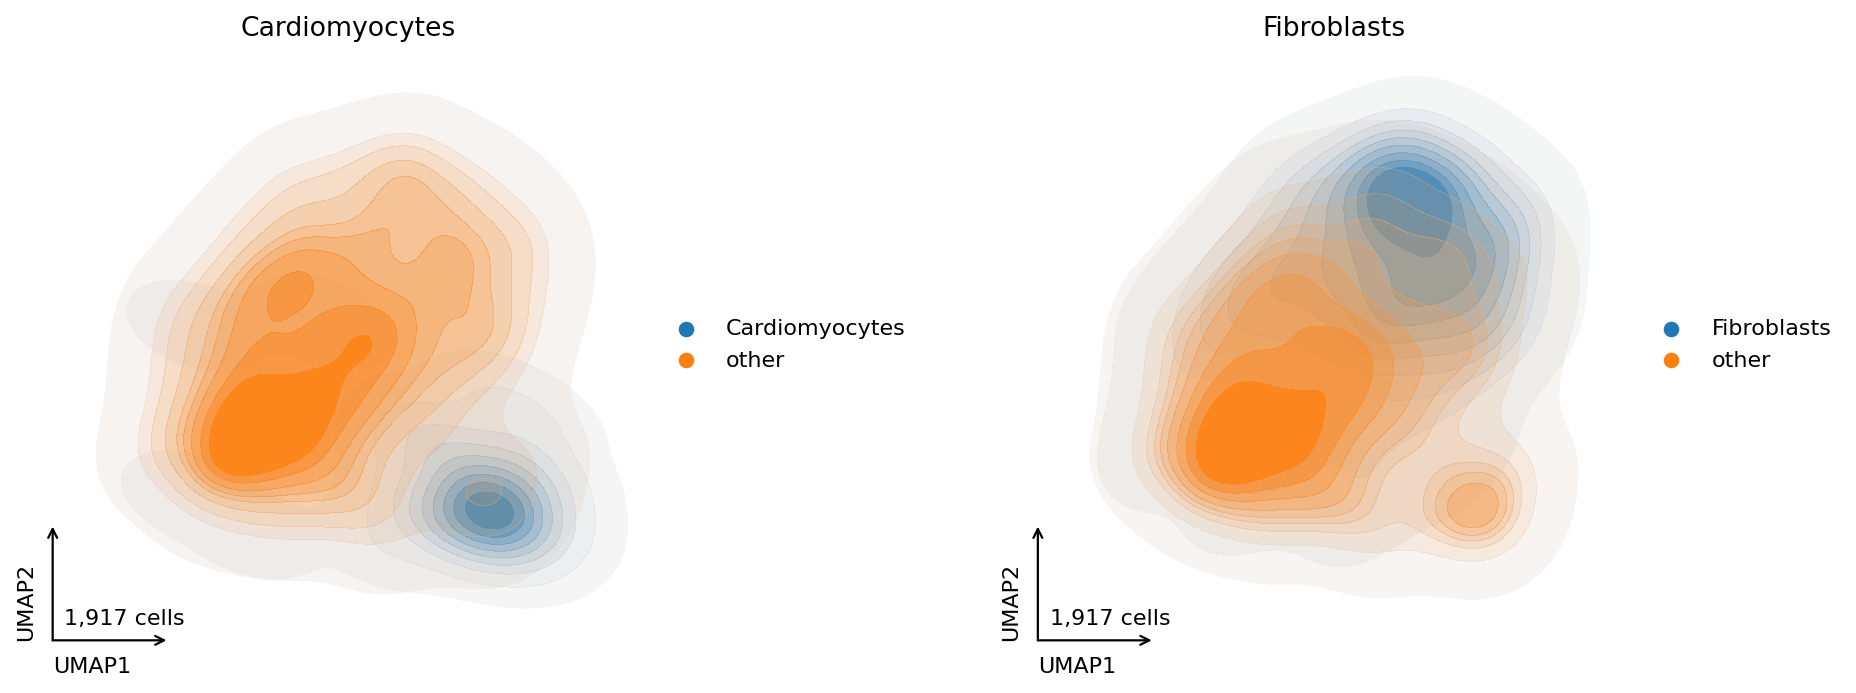

In [114]:
pl.embedding.plot_embedding(adata, color=['Cardiomyocytes', 'Fibroblasts'], style="density")

[<AxesSubplot: title={'center': 'Endothelial-cells'}, xlabel='UMAP1', ylabel='UMAP2'>,
 <AxesSubplot: title={'center': 'T-cells'}, xlabel='UMAP1', ylabel='UMAP2'>]

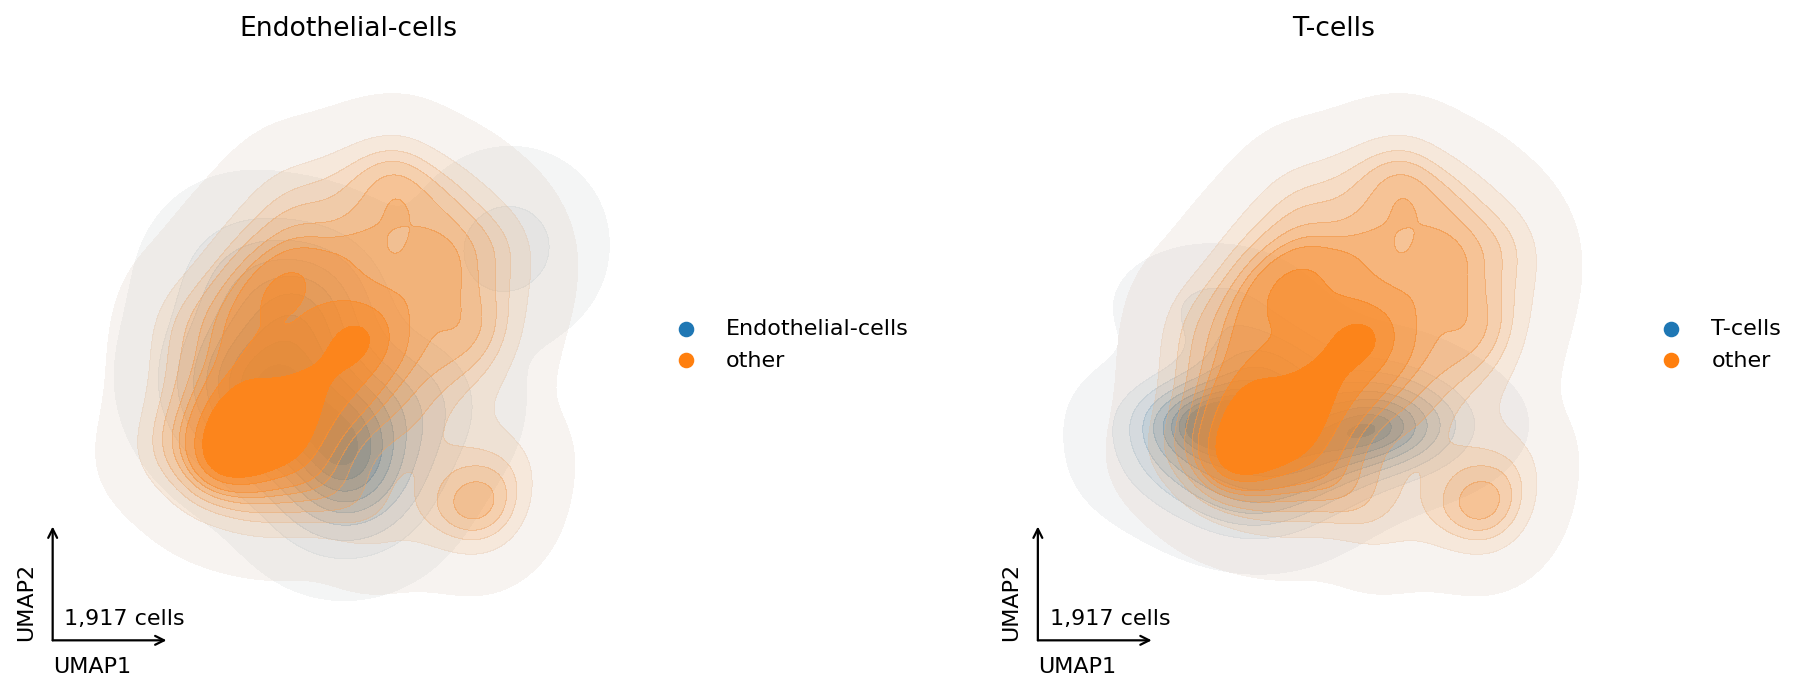

In [115]:
pl.embedding.plot_embedding(adata, color=['Endothelial-cells','T-cells'], style="density")

In [109]:
adata.obs.loc[~(adata.obs['ontology'] == 'Cardiomyocytes'), 'Cardiomyocytes_val'] = 0
adata.obs.loc[(adata.obs['ontology'] == 'Cardiomyocytes'), 'Cardiomyocytes_val'] = 1
adata.obs.loc[~(adata.obs['ontology'] == 'Fibroblasts'), 'Fibroblasts_val'] = 0
adata.obs.loc[(adata.obs['ontology'] == 'Fibroblasts'), 'Fibroblasts_val'] = 1
adata.obs.loc[~(adata.obs['ontology'] == 'Endothelial-cells'), 'Endothelial-cells_val'] = 0
adata.obs.loc[(adata.obs['ontology'] == 'Endothelial-cells'), 'Endothelial-cells_val'] = 1
adata.obs.loc[~(adata.obs['ontology'] == 'T-cells'), 'T-cells_val'] = 0
adata.obs.loc[(adata.obs['ontology'] == 'T-cells'), 'T-cells_val'] = 1

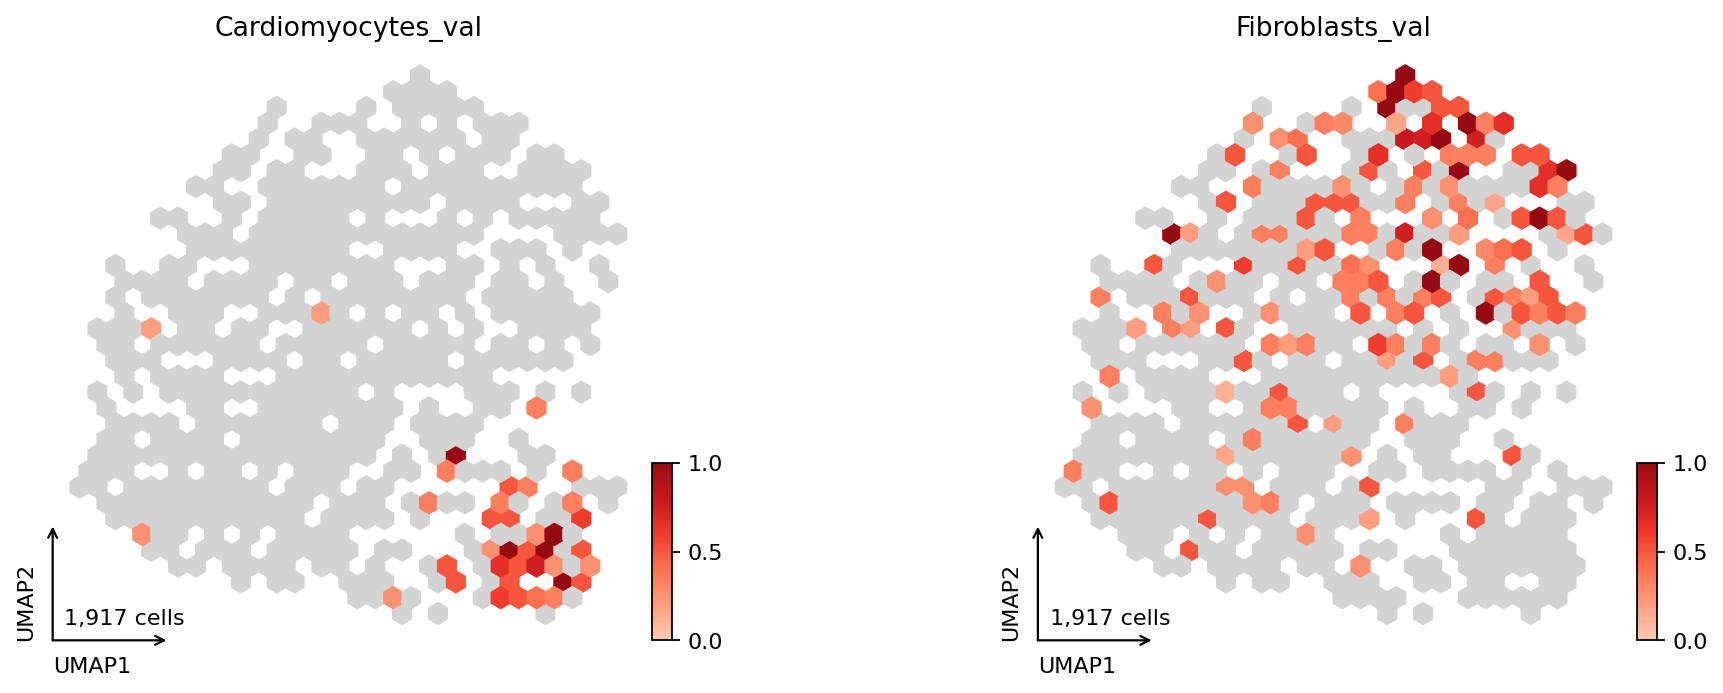

In [131]:
_ = pl.embedding.plot_embedding(adata, color=['Cardiomyocytes_val', 'Fibroblasts_val'], style="hexbin", save='hexbin_1.png')

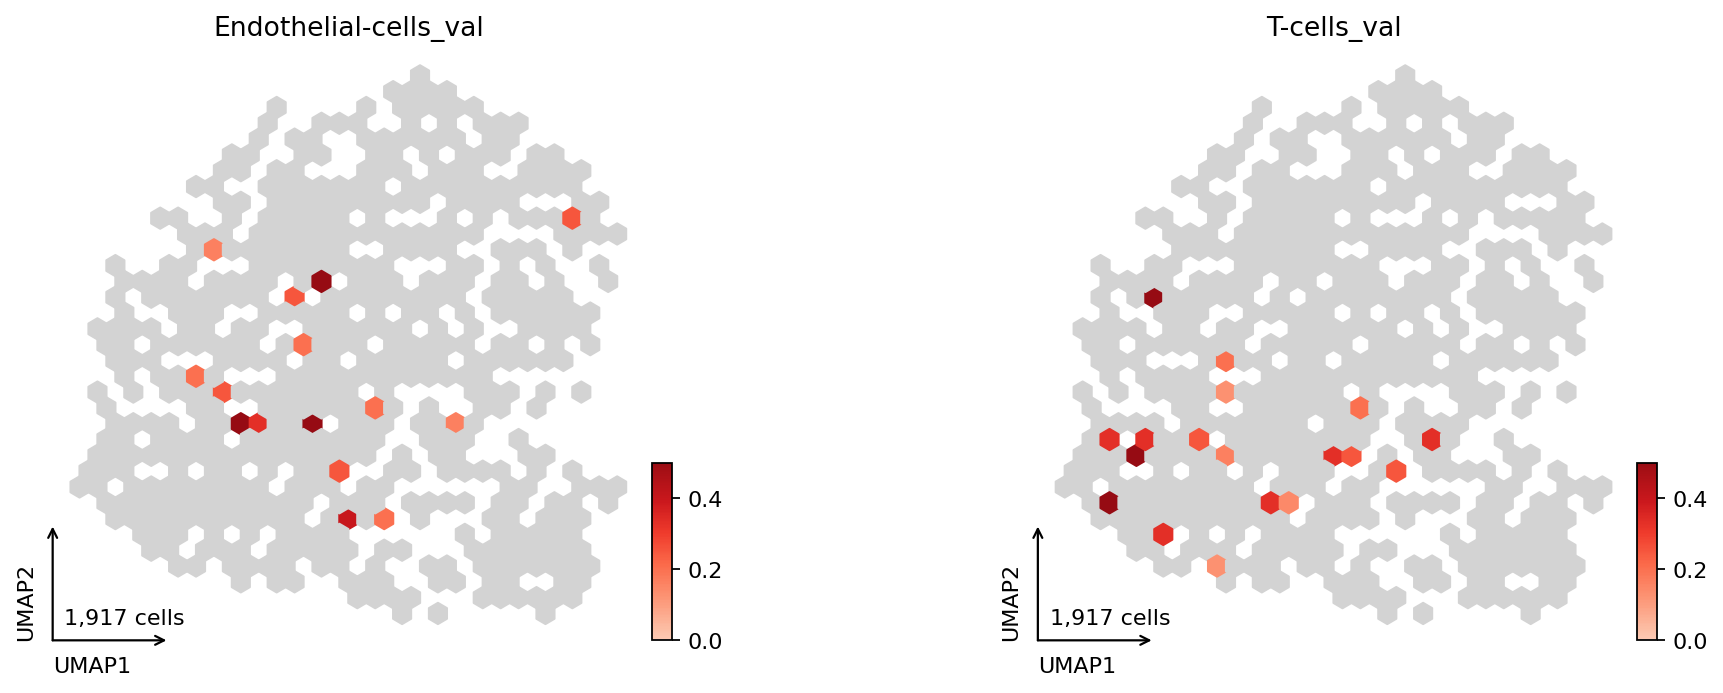

In [132]:
_ = pl.embedding.plot_embedding(adata, color=['Endothelial-cells_val','T-cells_val'], style="hexbin", save='hexbin_2.png')

## 7 - Plot distribution of cells across clusters

In [ ]:
_ = pl.qc_filter.n_cells_barplot(
    adata,
    "clustering",
    groupby=condition_column,
    save="cell_distribution_barplot.pdf"
)

________

## 8 - Generating 3D Object with UMAP coordinates in HTML

This optional step can be used to create a 3 dimensional UMAP. However, this is **disabled by default** since the process of optimizing in the 3D or higher dimensional space usually **degrades lower dimensional (2D) representation of the UMAP**. Set `n_components` >= 3 at the top of the notebook to enable this step but be aware of the implications.

<h1><center>⬐ Fill in input data here ⬎</center></h1>

In [7]:
%bgcolor PowderBlue

# plot 3D html for the "clustering" adata.obs, change to individual leiden or other columns if needed
column_3d = "clustering"

____

In [ ]:
if embedding == "umap" and n_components > 2:
    pl.embedding.plot_3D_UMAP(adata, column_3d, save=f"umap_3d_{column_3d}")
    html_file = sctoolbox.settings.full_figure_prefix + f"umap_3d_{column_3d}.html"

    from IPython.display import IFrame
    display(IFrame(src=html_file, width=800, height=400))

_________

## 9 - Annotate regions to genes
This function uses [UROPA](https://doi.org/10.1038/s41598-017-02464-y) to annotate regions to genes with a gtf file containing the genes as reference.

In [ ]:
tools.peak_annotation.annotate_adata(
    adata,
    GTF_PATH,
    config=None,
    best=True,
    threads=threads,
    coordinate_cols=None,
    temp_dir="tmp",
    inplace=True
)

In [ ]:
adata.var['gene_id'].unique()

__________

## 10 - Saving adata for next notebook

In [ ]:
utils.adata.save_h5ad(adata, "anndata_4.h5ad")

In [ ]:
sctoolbox.settings.close_logfile()